# Bias and Variance of Sparse Linear Regression #

In this notebook, you will explore numerically how sparse vectors change the rate at which we can estimate the underlying model. This corresponds to parts (a), (b), (c) of Homework 12.

First, some setup. We will only be using basic libraries.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following functions produce the ground truth matrix $A \in \mathbb{R}^{n \times d}$ (denoted by $U$ since it is unitary), as well as the vector $w^* \in \mathbb{R}^d$ and observations $y \in \mathbb{R}^n$. They have been implemented for you, but it is worth going through the code to observe its limitations.

In [6]:
def ground_truth(n, d, s):
    """
    Input: Two positive integers n, d. Requires n >= d >=s. If d<s, we let s = d
    Output: A tuple containing i) random matrix of dimension n X d with orthonormal columns. and
             ii) a d-dimensional, s-sparse wstar with (large) Gaussian entries
    """
    if d > n:
        print ("Too many dimensions") 
        return None
    
    if d < s:
        s = d
    A = np.random.randn(n, d) #random Gaussian matrix
    U, S, V = np.linalg.svd(A, full_matrices=False) #reduced SVD of Gaussian matrix
    wstar = np.zeros(d)
    wstar[:s] = 10 * np.random.randn(s)
    
    np.random.shuffle(wstar)
    return U, wstar

def get_obs(U, wstar):
    """
    Input: U is an n X d matrix and wstar is a d X 1 vector.
    Output: Returns the n-dimensional noisy observation y = U * wstar + z.
    """
    n, d = np.shape(U)
    z = np.random.randn(n) #i.i.d. noise of variance 1
    y = np.dot(U, wstar) + z
    return y


We now implement the estimators that we will simulate. The least squares estimator has already been implemented for you. You will be implementing the top k and threshold estimators in part (b), but it is fine to skip this for now and compile.

In [20]:
def LS(U, y):
    """
    Input: U is an n X d matrix with orthonormal columns and y is an n X 1 vector.
    Output: The OLS estimate what_{LS}, a d X 1 vector.
    """
    wls = np.dot(U.T, y) #pseudoinverse of orthonormal matrix is its transpose
    return wls


def thresh(U, y, lmbda):
    """
    Input: U is an n X d matrix and y is an n X 1 vector; lambda is a scalar threshold of the entries.
    Output: The estimate what_{T}(lambda), a d X 1 vector that is hard-thresholded (in absolute value) at level lambda.
            When code is unfilled, returns the all-zero d-vector.
    """
    n, d = np.shape(U)
    wls = LS(U, y)
    what = np.zeros(d)
    
    what[wls >= lmbda]  =wls[wls >= lmbda ]
    return what
    
    
def topk(U, y, s):
    """
    Input: U is an n X d matrix and y is an n X 1 vector; s is a positive integer.
    Output: The estimate what_{top}(s), a d X 1 vector that has at most s non-zero entries.
            When code is unfilled, returns the all-zero d-vector.
    """
    n, d = np.shape(U)
    what = np.zeros(d)
    wls = LS(U, y)
    
    inds = np.argsort(wls)
    topkinds = inds[range(s)]
    what[topkinds] = wls[topkinds]
    return what


The following helper function that we have implemented for you returns the error of all three estimators as a function
$n$, $d$, or $s$, depending on what you specify. Notice that it has the option to generate the true model with sparsity
that need not equal the sparsity demanded by the estimators.

Again, this function can be run without implementing the thresh and topk functions, but some of its returned values should then be ignored.

In [28]:
def error_calc(num_iters=10, param='n', n=1000, d=100, s=5, s_model=True, true_s=5):
    """
    Plots the prediction error 1/n || U(what - wstar)||^2 = 1/n || what - wstar ||^2 for the three estimators
    averaged over num_iter experiments.
    
    Input:
    Output: 4 arrays -- range of parameters, errors of LS, topk, and thresh estimator, respectively. If thresh and topk
            functions have not been implemented yet, then these errors are simply the norm of wstar.
    """
    wls_error = []
    wtopk_error = []
    wthresh_error = []
    
    if param == 'n':
        arg_range = np.arange(100, 2000, 50)
        lmbda = 2 * np.sqrt(np.log(d))
        for n in arg_range:
            U, wstar = ground_truth(n, d, s) if s_model else ground_truth(n, d, true_s)
            error_wls = 0
            error_wtopk = 0
            error_wthresh = 0
            for count in range(num_iters):
                y = get_obs(U, wstar)
                wls = LS(U, y)
                wtopk = topk(U, y, s)
                wthresh = thresh(U, y, lmbda)
                error_wls += np.linalg.norm(wstar - wls)**2
                error_wtopk += np.linalg.norm(wstar - wtopk)**2
                error_wthresh += np.linalg.norm(wstar - wthresh)**2
            wls_error.append(float(error_wls)/ n / num_iters)
            wtopk_error.append(float(error_wtopk)/ n / num_iters)
            wthresh_error.append(float(error_wthresh)/ n / num_iters)
        
    elif param == 'd':
        arg_range = np.arange(10, 1000, 50)
        for d in arg_range:
            lmbda = 2 * np.sqrt(np.log(d))
            U, wstar = ground_truth(n, d, s) if s_model else ground_truth(n, d, true_s)
            error_wls = 0
            error_wtopk = 0
            error_wthresh = 0
            for count in range(num_iters):
                y = get_obs(U, wstar)
                wls = LS(U, y)
                wtopk = topk(U, y, s)
                wthresh = thresh(U, y, lmbda)
                error_wls += np.linalg.norm(wstar - wls)**2
                error_wtopk += np.linalg.norm(wstar - wtopk)**2
                error_wthresh += np.linalg.norm(wstar - wthresh)**2
            wls_error.append(float(error_wls)/ n / num_iters)
            wtopk_error.append(float(error_wtopk)/ n / num_iters)
            wthresh_error.append(float(error_wthresh)/ n / num_iters)
    
    elif param == 's':
        arg_range = np.arange(5, 55, 5)
        lmbda = 2 * np.sqrt(np.log(d))
        for s in arg_range:
            U, wstar = ground_truth(n, d, s) if s_model else ground_truth(n, d, true_s)
            error_wls = 0
            error_wtopk = 0
            error_wthresh = 0
            for count in range(num_iters):
                y = get_obs(U, wstar)
                wls = LS(U, y)
                wtopk = topk(U, y, s)
                wthresh = thresh(U, y, lmbda)
                error_wls += np.linalg.norm(wstar - wls)**2
                error_wtopk += np.linalg.norm(wstar - wtopk)**2
                error_wthresh += np.linalg.norm(wstar - wthresh)**2
            wls_error.append(float(error_wls)/ n / num_iters)
            wtopk_error.append(float(error_wtopk)/ n / num_iters)
            wthresh_error.append(float(error_wthresh)/ n / num_iters)
    
    return arg_range, wls_error, wtopk_error, wthresh_error

We are now ready to perform the parts of the question.

# Part (a) #

As an example, in the following cell, we run the helper function above to return error values of the OLS estimate for various values of $n$. You are required to:

1) Plot the error as a function of $n$. You may find a log-log plot useful to see the expected bahavior.

2) Run the helper function to return the error as a function of $d$ and $s$, and plot your results.

You need to have 3 plots in your answer. Make sure to label axes properly, and to make the plotting visible in general. Feel free to play with the parameters, but ensure that your answer describes your parameter choices. At this point, s_model is True, since we are only interested in the variance of the model.

Text(0,0.5,'Error')

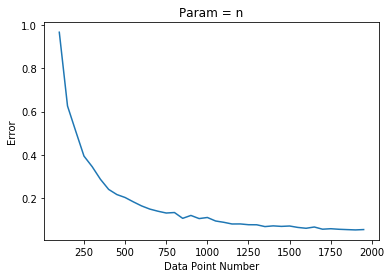

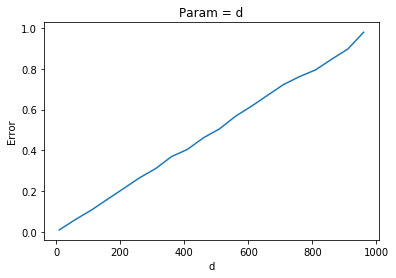

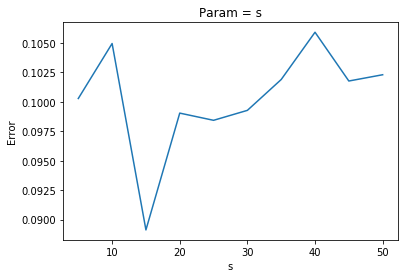

In [14]:
#nrange contains the range of n used, ls_error the corresponding errors for the OLS estimate
nrange, ls_error, _, _ = error_calc(num_iters=10, param='n', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, ls_error)
plt.xlabel('Data Point Number')
plt.title('Param = n')
plt.ylabel('Error')


nrange, ls_error, _, _ = error_calc(num_iters=10, param='d', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, ls_error)
plt.xlabel('d')
plt.title('Param = d')
plt.ylabel('Error')


nrange, ls_error, _, _ = error_calc(num_iters=10, param='s', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, ls_error)
plt.xlabel('s')
plt.title('Param = s')
plt.ylabel('Error')





Are these plots as expected? Discuss. Also put down your parameter choices (either here or in plot captions.) It's fine to use the default values, but put them down nonetheless.

### They are as expected. For LS, the higher the dimensions, the more the bias error. Moreover, the higher the complexity of our Model. S, the sparsity is unrelated to our OLS solver, so as expected, the error is uncorrelated to the sparsity s. Also, as n increases, as expected, the error decreases, as the effect of noise has less effect on our most likely weights. Optimal : d = 1 , n = infinity , s = anything. 

# Part (b) #
Now fill out the functions implementing the sparsity-seeking estimators: thresh, and topk in the above cells. You should be able to test these functions using some straightforward examples.

We will now simulate the error of all the estimators, as a function of $n$, $d$, and $s$. An example of this for $n$ is given below. You must:

1) Plot the error of all estimators as a function of $n$.

2) Run the helper function to sweep over $d$ and $s$, and plot the behavior of all three estimators.

You should report 3 plots here once again. Make sure to make them fully readable.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


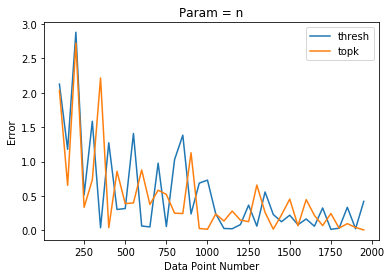

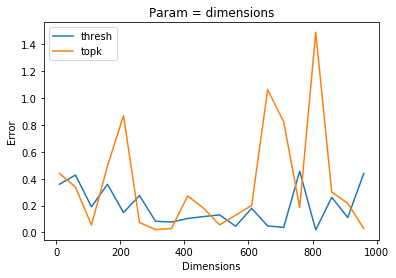

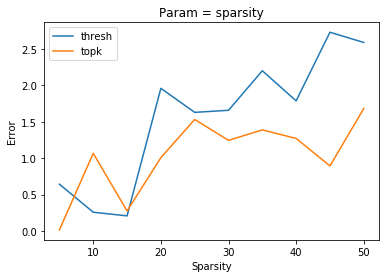

In [34]:
nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='n', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Data Point Number')
plt.title('Param = n')
plt.ylabel('Error')
plt.legend({'topk', 'thresh'})

nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='d', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Dimensions')
plt.title('Param = dimensions')
plt.ylabel('Error')
plt.legend() 
plt.legend({'topk', 'thresh'})

nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='s', n=1000, d=100, s=5, s_model=True, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Sparsity')
plt.title('Param = sparsity')
plt.ylabel('Error')
plt.legend() 
plt.legend({'topk', 'thresh'})






# Part (c) #

Now, call the helper function with the true sparsity being greater than the sparsity assumed by the top-k estimator. Remember to set s_model to False! Plot the behavior of all three estimators once again, as a function of $n$, $d$, $s$, where $s$ is the assumed sparsity of the top-k model.

You should return 3 plots, and explain what you see in terms of the bias variance tradeoff.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


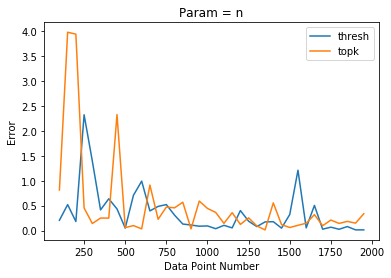

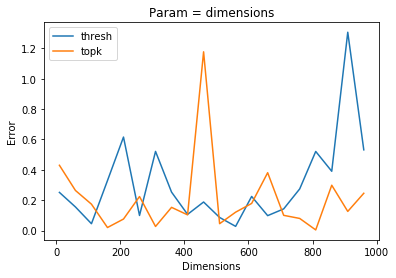

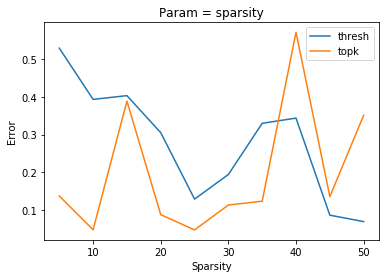

In [38]:
nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='n', n=1000, d=100, s=5, s_model=False, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Data Point Number')
plt.title('Param = n')
plt.ylabel('Error')
plt.legend({'topk', 'thresh'})

nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='d', n=1000, d=100, s=5, s_model=False, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Dimensions')
plt.title('Param = dimensions')
plt.ylabel('Error')
plt.legend() 
plt.legend({'topk', 'thresh'})

nrange, _,wtopk_error, wthresh_error= error_calc(num_iters=10, param='s', n=1000, d=100, s=5, s_model=False, true_s=5)

plt.figure() 
plt.plot(nrange, wtopk_error, nrange, wthresh_error)
plt.xlabel('Sparsity')
plt.title('Param = sparsity')
plt.ylabel('Error')
plt.legend() 
plt.legend({'topk', 'thresh'})






### In the Model we see that with higher dimensional data we don't get more error, that is because we are setting our complexity within our sparsity to be set. Therefore, our variance is set, and our bias is already high. However when looking at the assumed sparsity of our model (which should be 100, since we don't have any sparsity), we see that the error stays the same. The randomness comes from our noise, however there seems to be no visible trend. We expect that as we increase sparsity, the more our error will decrease because we are approaching optimal variance and bias tradeoff as we approach the true model. 